In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import sklearn
from sklearn import linear_model, metrics, preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import r2_score, f1_score

%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
os.getcwd()

'/home/matan'

In [4]:
def load_dataset(file_name):
    return pd.read_csv(file_name)


In [5]:
df = load_dataset('sientinst_data_merged.csv')

## Table of Contents
* [Chapter 1](#chapter1)
    * [Section 1.1](#section_1_1)
        * [Sub Section 1.1.1](#sub_section_1_1_1)
* [Chapter 2](#chapter2)
    * [Section 2.1](#section_2_1)
        * [Sub Section 2.1.1](#sub_section_2_1_1)
        * [Sub Section 2.1.2](#sub_section_2_1_2)
    * [Section 2.2](#section_2_2)
        * [Sub Section 2.2.1](#sub_section_2_2_1)
        * [Sub Section 2.2.2](#sub_section_2_2_2)
* [Chapter 3](#chapter3)
    * [Section 3.1](#section_3_1)
        * [Sub Section 3.1.1](#sub_section_3_1_1)
        * [Sub Section 3.1.2](#sub_section_3_1_2)
    * [Section 3.2](#section_3_2)
        * [Sub Section 3.2.1](#sub_section_3_2_1)
        * [Sub Section 3.2.2](#sub_section_3_2_2)

## Data cleansing
>_*"the process of detecting and correcting (or removing) corrupt or inaccurate records from a record set, table, or database and refers to identifying incomplete, incorrect, inaccurate or irrelevant parts of the data and then replacing, modifying, or deleting the dirty or coarse data"*_  
~Wikipedia  

Some rows had more than 15 columns, which happend to be a mistake

Data to clean 
* people that do not conduct research 
* people we couldnt find their gender

Columns to edit 
* Position --change to scale from 0 to 4
    0 No Degree
    1 Bachelors Degree
    2 Maters Degree
    3 Doctor Of Philosophy
    4 Proffesor (Part time or Full)
* Categories for contries (with sk label)

Add columns with statistics of each contry such as 
* Human Development Index
* PISA score - Programme for International Student Assessment 
* GDP - gross domestic product

In [6]:
def cleansing(df): # Inplace
    len_before = len(df['Reads'])
    df.drop(df[df['Shanghai_ranking'].str.isnumeric() == False].index, inplace = True)
    df.drop(df[df['Publications'].str.isnumeric() == False].index, inplace = True)
    df.drop(df[df['Reads'].str.isnumeric() == False].index, inplace = True)
    df.drop(df[df['Citations'].str.isnumeric() == False].index, inplace = True)
    df.drop(df[df['Interest score'].str.isnumeric() == False].index, inplace = True)
    len_after = len(df['Reads'])
    print(str(len_before-len_after)+" rows were removed")
    df.to_csv('sientist_data_cleansing')

In [7]:
cleansing(df)
df.head()

975 rows were removed


Full name  Gender  \
0          Thomas Serre    male   
1       Abdullah Chahin    male   
2     Richard M Mariita    male   
3  Sharon Miriam Swartz  female   
4         Roberto Zenit    male   

                                            Position         Nation  \
0                                                PhD  United States   
1                                                 MD  United States   
2  BEd (Science), MSc (Microbiology) both from Ke...  United States   
3                   Ph.D., The University of Chicago  United States   
4                                              Ph.D.  United States   

          Institute Shanghai_ranking  \
0  Brown University               47   
1  Brown University               47   
2  Brown University               47   
3  Brown University               47   
4  Brown University               47   

                                          Depratment  \
0  Department of Cognitive, Linguistic and Psycho...   
1                   Division of Infectious Diseases    
2                            Department of Chemistry   
3     Department of Ecology and Evolutionary Biology   
4                        Brown School of Engineering   

                                         Disciplines Publications Citations  \
0  Machine Vision|Object Recognition|Machine Lear...          183     11905   
1                 Sepsis|ICU|Intensive Care Medicine           62       234   
2                          Microbiology|Genomics|PCR           39       286   
3                       Zoology|Biomechanics|Mammals          152      4510   
4  Numerical Simulation|Fluid Mechanics|Fluid Dyn...          235      3444   

  Recommendations                                 Top cited research  \
0              64  HMDB51: A Large Video Database for Human Motio...   
1               5             False alarm reduction in critical care   
2              55  Antitubercular and Phytochemical Investigation...   
3              45  The 'Law of Bone Transformation': A Case of Cr...   
4             141        Particle-wall collisions in a viscous fluid   

  Interest score  Reads h index  \
0           6087  33978      40   
1           1379   3586       9   
2           1959   4724       7   
3           2329  37724      39   
4           2294  48142      31   

                                                 URL  
0  https://www.researchgate.net/profile/Thomas-Serre  
1  https://www.researchgate.net/profile/Abdullah_...  
2  https://www.researchgate.net/profile/Richard_M...  
3  https://www.researchgate.net/profile/Sharon-Sw...  
4  https://www.researchgate.net/profile/Roberto-Z...

to find genders of scientists we use the API / Dataset from Facebook https://github.com/philipperemy/name-dataset
using `pip install name-dataset`

In [9]:
from names_dataset import NameDataset, NameWrapper
nd = NameDataset() # uses 3.2 GB of RAM , use with caution 

In [11]:
def find_gender(name):
    try:
        x = nd.search(name)['first_name']['gender']
        if x['Male'] >= x['Female']:
            return 'Male'
        else:
            return 'Female'
    except: 
        return 'NaN'
first_names = df['Full name'].str.split(' ').apply(lambda x: x[0])
genders_list = list()
for name in first_names:
    genders_list.append(find_gender(name))
df['Gender'] = genders_list

the amount of entries to remove (Gender Not defined)

In [12]:
print(str(len(df[df['Gender']=='NaN']))+" sientists were removed (not determied gender)")

39685 sientists were removed (not determied gender)


In [13]:
df.drop(df[df['Gender'] == "NaN"].index ,inplace = True)
df.to_csv('sientist_data_cleansing_geneder_clear.csv')

In [10]:
df = load_dataset('sientist_data_cleansing_geneder_clear.csv')

in the following cell we remove all people which apear not being a sientists:
that means they have no publications, reads and ect.

In [11]:
try:
    df.drop(["Unnamed: 0"], axis=1, inplace=True)
except:
     print ("")

series_to_remove = df[df['Publications'].astype(int) + df['Citations'].astype(int)
                      + df['Recommendations'].astype(int) + df['Interest score'].astype(int)+
                      df['Reads'].astype(int)+ df['h index'].astype(int) == 0].index

print(str(len(series_to_remove))+" sientists were removed (apear to not being sientists)")

df.drop(series_to_remove, inplace = True);
df.drop_duplicates();

3051 sientists were removed (apear to not being sientists)


### Ouliers

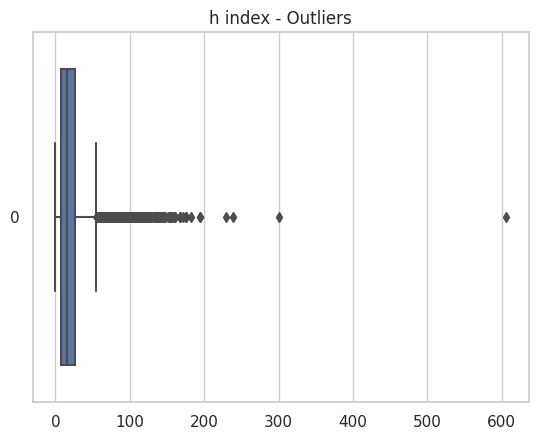

In [12]:
sns.set(style="whitegrid")
sns.boxplot(df["h index"], orient="h");
plt.title("h index - Outliers");

In [13]:
df[df["h index"]>600]

Full name  Gender Position  Nation  \
9265  Cynthia Edenburg  Female      PhD  Israel   

                          Institute  Shanghai_ranking  \
9265  The-Open-University-of-Israel               201   

                                             Depratment  \
9265  Department of History, Philosophy and Judaic S...   

                                        Disciplines  Publications  Citations  \
9265  Distance Education|Online Learning|E-Learning            19         65   

      Recommendations                                 Top cited research  \
9265                0  How (not) to murder a king: Variations on a th...   

      Interest score  Reads  h index URL  
9265              26    338      606   3

In [14]:
df.drop(df[df["h index"]>600].index, inplace = True)

We've search for Cynthia Edenburg, and it seems that her h index is wrongly calcualtely.
So we decide that she's an outlier

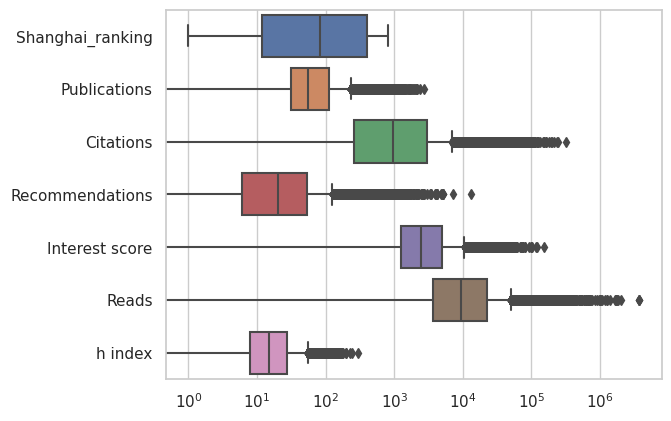

In [15]:
sns.set(style="whitegrid")

# we scale X-axis logaritmically
plt.xscale('log')

sns.boxplot(df, orient="h");

In [16]:
df[df["Reads"]>3500000]

Full name  Gender  \
1705       Goodarz Danaei    Male   
11623  Lital Keinan-Boker  Female   
27472    Regina M Fisberg  Female   

                                          Position         Nation  \
1705   Professor (Associate) at Harvard University  United States   
11623                                 MD, PhD, MPH         Israel   
27472                          Associate Professor         Brazil   

                     Institute  Shanghai_ranking  \
1705        Harvard University                 1   
11623      University-of-Haifa               501   
27472  University-of-Sao-Paulo               101   

                                        Depratment  \
1705   Department of Global Health and Population    
11623                      School of Public Health   
27472          Department of Nutrition (São Paulo)   

                                             Disciplines  Publications  \
1705   Epidemiologic Studies|Hypertension|Epidemiolog...           306   
11623                Cancer|Phytoestrogens|Breast Cancer           297   
27472                  Hypertension|Nutrition|Metabolism           362   

       Citations  Recommendations  \
1705       70185             1306   
11623      25504              759   
27472       6278              429   

                                      Top cited research  Interest score  \
1705   A comparative risk assessment of burden of dis...           35390   
11623  Worldwide trends in body-mass index, underweig...           13242   
27472  Global sodium consumption and death from cardi...            3524   

         Reads  h index                                                URL  
1705   3726175       72  https://www.researchgate.net/profile/Goodarz-D...  
11623  3674694       48  https://www.researchgate.net/profile/Lital-Kei...  
27472  3665645       42                                                NaN

In [17]:
df[df["Recommendations"]>10000]

Full name Gender                                           Position  \
1680  Manu Mangattu   Male  English Professor | Author | NET English Mento...   

             Nation           Institute  Shanghai_ranking  \
1680  United States  Harvard University                 1   

                 Depratment  \
1680  Department of English   

                                            Disciplines  Publications  \
1680  Arts and Humanities|Critical Theory|Literature...           112   

      Citations  Recommendations  \
1680          1            13102   

                                     Top cited research  Interest score  \
1680  Traversing High and Low Culture: Knowledge, We...            3176   

       Reads  h index                                                URL  
1680  693066        1  https://www.researchgate.net/profile/Manu-Mang...

In [18]:
try:
    df.drop(["URL"], axis=1, inplace=True)
except:
     print ("")

we want to add PISA rank & GDP columns:

In [32]:
nation_pisa_science = {"Israel":43, "United States":19, "Great Britain":15, "France":25,
                       "Switzerland":24, "Canada":9, "Japan":6,"China":1,"Turkey":40,
                       "South Korea":8,"Iceland":36,"India":73,"Cyprus":48,"Sweden":20,
                       "Finland":7,"Iran":100,"Malaysia":48,"Italy":40,"Spain":31,"Chile":59,
                       "Brazil":65 ,"Colombia":63,"Mexico":58,"Argentina":65}

nation_GDP = {"Israel":488527, "United States":23315081, "Great Britain":3131378
                      ,"France":2957880 , "Switzerland":800640 , "Canada":1988336
                      ,"Japan":4940878 ,"China":17734063 ,"Turkey":819035
                      ,"South Korea":419015 ,"Iceland":25602 ,"India":3176295
                      ,"Cyprus":28408 ,"Sweden":635664 , "Finland":297302
                      ,"Iran":359713 ,"Malaysia":372981 ,"Italy":2107703
                      ,"Spain":1427381 ,"Chile": 317059 ,"Brazil":1608981
                      ,"Colombia":314464 ,"Mexico":1272839 ,"Argentina":487227}

nation_HDI_score = {"Israel":0.919, "United States":0.921, "Great Britain":0.929, 
                    "France":0.903, "Switzerland":0.962, "Canada":0.936, "Japan":0.925,
                    "China":0.768,"Turkey":0.838,"South Korea":0.925,"Iceland":0.959,
                    "India":0.633,"Cyprus":0.896,"Sweden":0.947,"Finland":0.940,
                    "Iran":0.774,"Malaysia":0.803,"Italy":0.895,"Spain":0.905,
                    "Chile":0.855,"Brazil":0.754 ,"Colombia":0.752,"Mexico":0.758,
                    "Argentina":0.842}

def country_to_pisa_rank(country):
    pisa = []
    for x in country:
        pisa.append(nation_pisa_science[x])
    return pisa

def country_to_GDP(country):
    GDP = []
    for x in country:
        GDP.append(nation_GDP[x])
    return GDP

def country_to_HDI(country):
    HDI = []
    for x in country:
        HDI.append(nation_HDI_score[x])
    return HDI

df['PISA rank'] = country_to_pisa_rank(df['Nation'])
df['GDP (Millions $)'] = country_to_GDP(df['Nation'])
df['HDI score'] = country_to_HDI(df['Nation'])
df.head(2)

Full name Gender Position         Nation         Institute  \
0     Thomas Serre   Male      PhD  United States  Brown University   
1  Abdullah Chahin   Male       MD  United States  Brown University   

   Shanghai_ranking                                         Depratment  \
0                47  Department of Cognitive, Linguistic and Psycho...   
1                47                   Division of Infectious Diseases    

                                         Disciplines  Publications  Citations  \
0  Machine Vision|Object Recognition|Machine Lear...           183      11905   
1                 Sepsis|ICU|Intensive Care Medicine            62        234   

   Recommendations                                 Top cited research  \
0               64  HMDB51: A Large Video Database for Human Motio...   
1                5             False alarm reduction in critical care   

   Interest score  Reads  h index  PISA rank  GDP (Millions $)  Position rank  \
0            6087  33978       40         19          23315081              3   
1            1379   3586        9         19          23315081              2   

   HDI score  
0      0.921  
1      0.921

Scaled categorial variables:
* profesor -> 4
* Ph.D -> 3
* Master -> 2
* Bachelor -> 1
* Other / None -> 0

In [110]:
def position_to_rank(position):
    try:
        position = position.replace(",", "").replace(".", "").replace("_", "").replace("-", "")
        position = position.lower()
    except:
        return 0
    
    if position.find("prof") != -1:
        return 4
    elif position.find("ph") != -1 or position.find("doc") != -1 or position.find("ds") != -1:
        return 3
    elif position.find("md") != -1 or position.find("ma") != -1 or position.find("ms") != -1:
        return 2
    elif position.find("ba") != -1 or position.find("bs") != -1 or position.find("be") != -1:
        return 1
    else:
        return 0

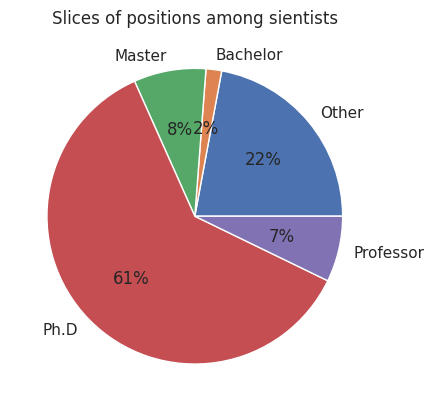

In [111]:
sns.set(style="whitegrid")
edu_rank = []

for pos in df["Position"]:
    val = position_to_rank(pos)
    edu_rank.append(val)

cnt_lst = [edu_rank.count(0), edu_rank.count(1),
          edu_rank.count(2), edu_rank.count(3),
          edu_rank.count(4)]

mylabels = ["Other", "Bachelor", "Master", "Ph.D", "Professor"]

plt.pie(cnt_lst, labels = mylabels, autopct='%1.f%%');
plt.title("Slices of positions among sientists");
# plt.bar(mylabels, cnt_lst);

# adding as an additional column
df['Position rank'] = edu_rank

We see that the majority of the sientists are Ph.D and very few are professors and lower to Ph.D.

We assume that:
* Naturally there are mush less professors than Ph.Ds
* Professors may retired very ofen due to their age, or may be less ambitious than young Ph.Ds
* Professors might be much more buzy in lecturing, pedagogy and other activities rather than in researchs
* Only 2% are Bachelors and it does make sence, because naturally the may countinue to their Master degree or leave the academic enviorment, rather than being involved in researchs
* Many of the Master degrees require a thesis

# Exploratory Data Analysis 
>_*"An approach of analyzing data sets to summarize their main characteristics,  
often using statistical graphics and other data visualization methods"*_  
~Wikipedia

In this section we will disscuse the corallation between the parameters we had collected between themselves and their impact on the h index:

In [34]:
disciplines = df[df['Disciplines'] != "Nan"]['Disciplines'].apply(lambda x:x.split('|'))
L = list()
for entrie in disciplines:
    for item in entrie:
        L.append(item)

text = str()
for item in L: 
    text= text +item +' '

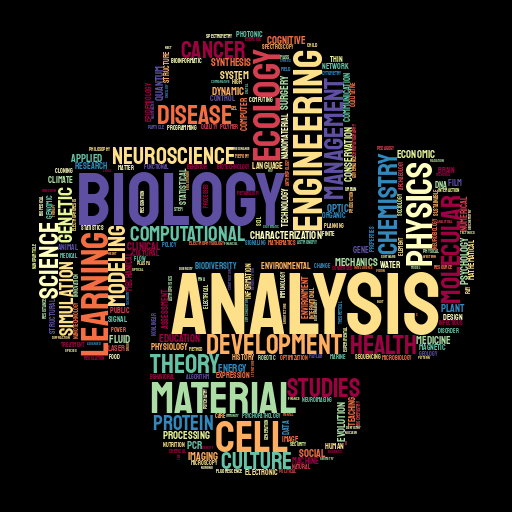

In [16]:
import stylecloud

with open('SJ-Speech.txt', 'w') as f:
    f.write(text)

stylecloud.gen_stylecloud(file_path='SJ-Speech.txt',
                          icon_name='fab fa-python',
                          palette='colorbrewer.diverging.Spectral_11',
                          output_name='cloud.png',
                          background_color='black',
                          collocations=False)

from IPython.display import Image
Image(filename='cloud.png') 

Disciplines which receive nowadays' most attention, according the the database we had collected.

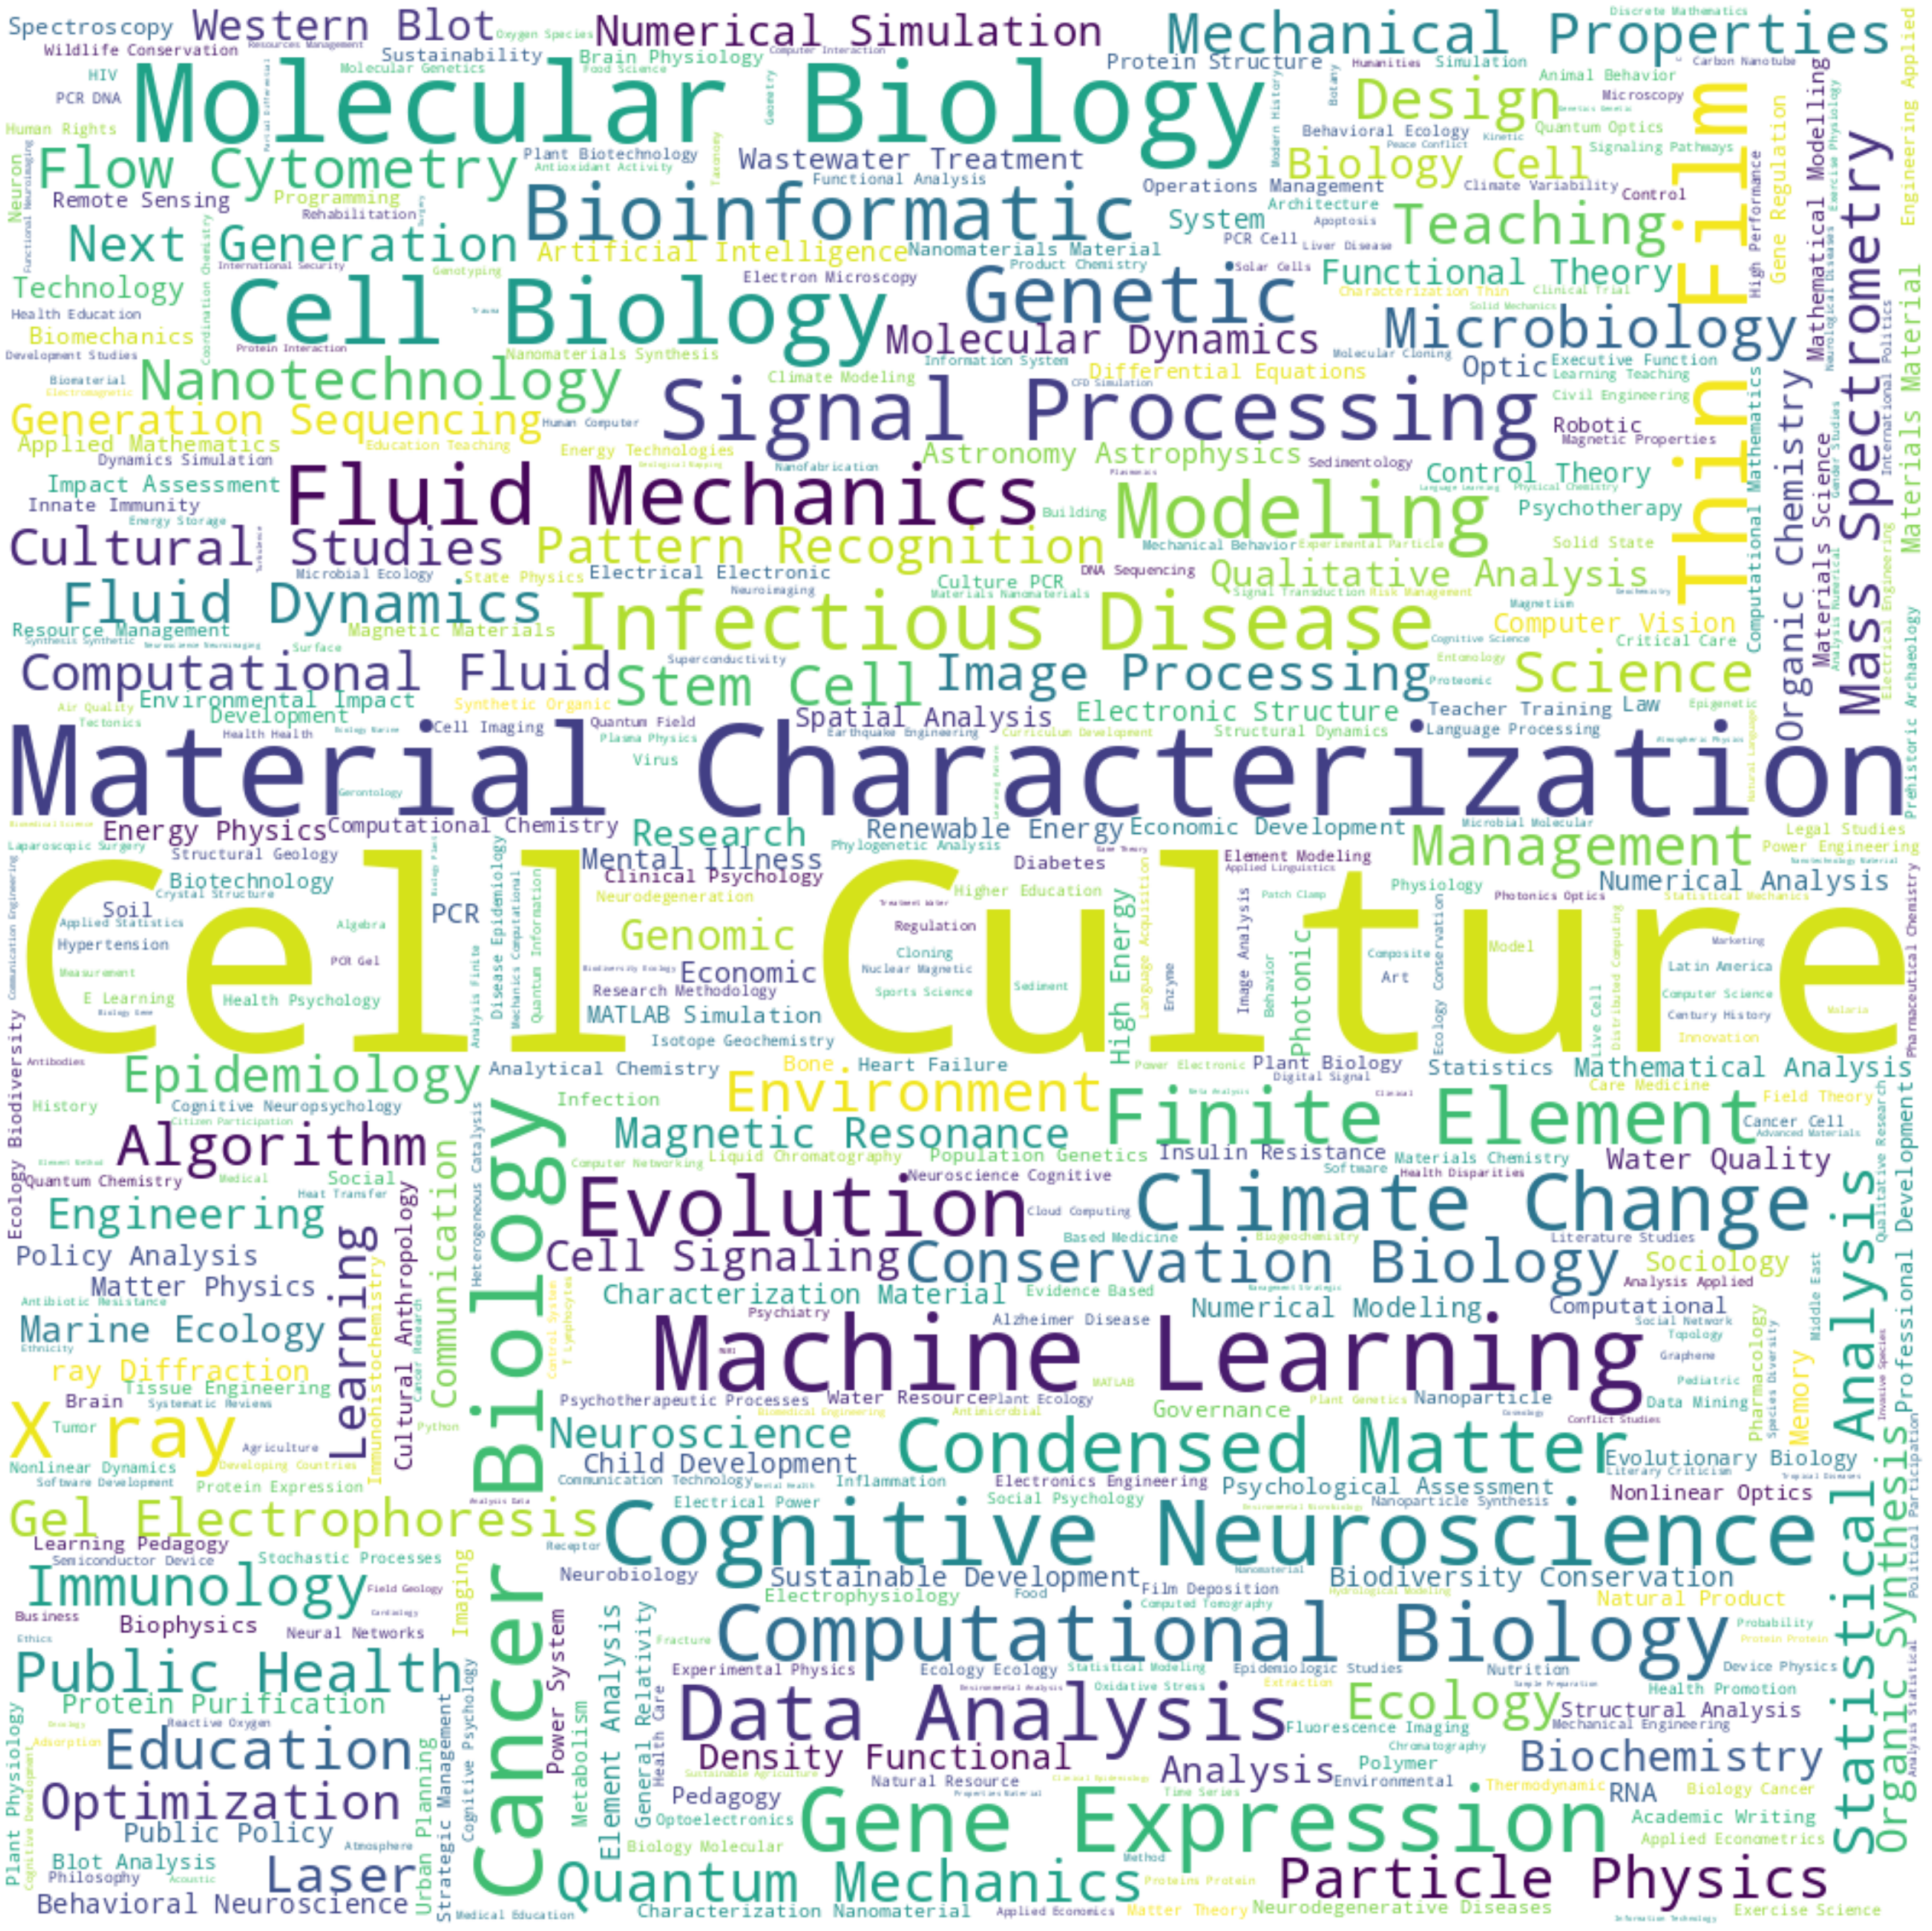

In [17]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

wordcloud = WordCloud(height = 1000, width =1000, max_font_size=200, max_words=500, background_color="white").generate(text)
plt.figure(figsize=(60, 100), dpi=70)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

### Scatter plots

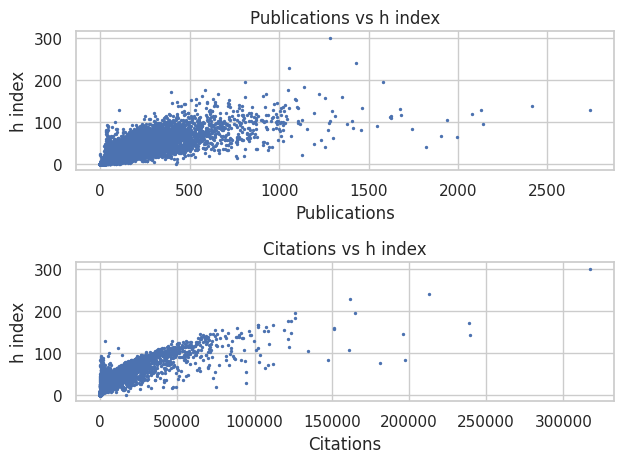

In [22]:
fig, (ax1, ax2) = plt.subplots(2, 1)
# fig.suptitle('Correlations to h index')

data={'Publications':df['Publications'].tolist(),
      'h index':df['h index'].tolist()}

tmp_df = pd.DataFrame(data = data);
tmp_df.plot.scatter(x = 'Publications', y = 'h index', s = 2, ax=ax1);

data={'Citations':df['Citations'].tolist(),
      'h index':df['h index'].tolist()}
  
tmp_df = pd.DataFrame(data = data);
tmp_df.plot.scatter(x = 'Citations', y = 'h index', s = 2, ax=ax2);

ax1.set_title("Publications vs h index");
ax2.set_title("Citations vs h index");
fig.tight_layout()

* We see that some sientists have very high h index altought they published 'few' researchs and their cirations are moderate. That is probably because their very few researchs were very wide-spread.
* very few sientists whom published few researchs recived low h index, which means that is a key requirment for successing as a scientinst.

__we know that citations and publications are the only factor when calculating the h index.  
we want the see ehat is the impact of the other parameters on the h index, and perhaps we could  
invent a better index for perdicting the success of a sientist__

Here is the others correlations:

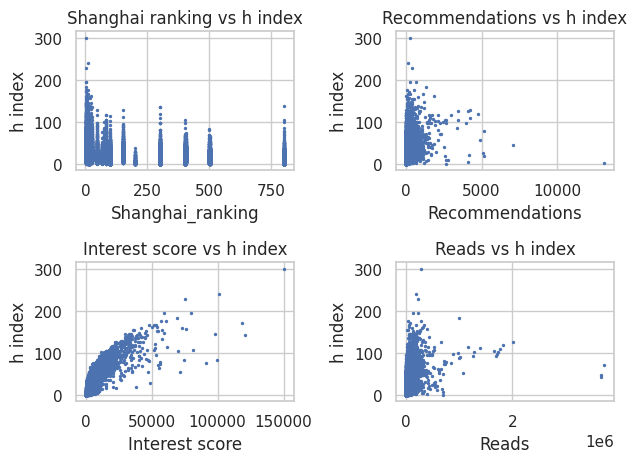

In [23]:
# fig.suptitle('Correlations to h index')

fig, axs = plt.subplots(2, 2)

data={'Shanghai_ranking':df['Shanghai_ranking'].tolist(),
      'h index':df['h index'].tolist()}

tmp_df = pd.DataFrame(data = data);
tmp_df.plot.scatter(x = 'Shanghai_ranking', y = 'h index', s = 2, ax=axs[0, 0]);

data={'Recommendations':df['Recommendations'].tolist(),
      'h index':df['h index'].tolist()}
  
tmp_df = pd.DataFrame(data = data);
tmp_df.plot.scatter(x = 'Recommendations', y = 'h index', s = 2, ax=axs[0, 1]);

data={'Interest score':df['Interest score'].tolist(),
      'h index':df['h index'].tolist()}

tmp_df = pd.DataFrame(data = data);
tmp_df.plot.scatter(x = 'Interest score', y = 'h index', s = 2, ax=axs[1, 0]);

data={'Reads':df['Reads'].tolist(),
      'h index':df['h index'].tolist()}
  
tmp_df = pd.DataFrame(data = data);
tmp_df.plot.scatter(x = 'Reads', y = 'h index', s = 2, ax=axs[1, 1]);

axs[0, 0].set_title("Shanghai ranking vs h index");
axs[0, 1].set_title("Recommendations vs h index");
axs[1, 0].set_title("Interest score vs h index");
axs[1, 1].set_title("Reads vs h index");
fig.tight_layout()

### Nation analysis

PISA rank and GDP ranking not giving much information. we would try to find the avarage h index for each nation.  

In [73]:
mini_df = df.groupby(['Nation']).mean()["h index"]

avg_h_index = mini_df.tolist()
nations = ['Argentina', 'Brazil', 'Canada', 'Chile', 'China', 'Colombia', 'France',
          'Great Britain', 'Israel', 'Japan', 'Mexico', 'Switzerland', 'United States']

mini_df = pd.DataFrame({"Nation":nations, "Average h index":avg_h_index})

mini_df['PISA rank'] = country_to_pisa_rank(mini_df['Nation'])
mini_df['GDP (Millions $)'] = country_to_GDP(mini_df['Nation'])
mini_df['HDI score'] = country_to_HDI(mini_df['Nation'])
mini_df.head(1)

Nation  Average h index  PISA rank  GDP (Millions $)  HDI score
0  Argentina        13.673216         65            487227      0.842

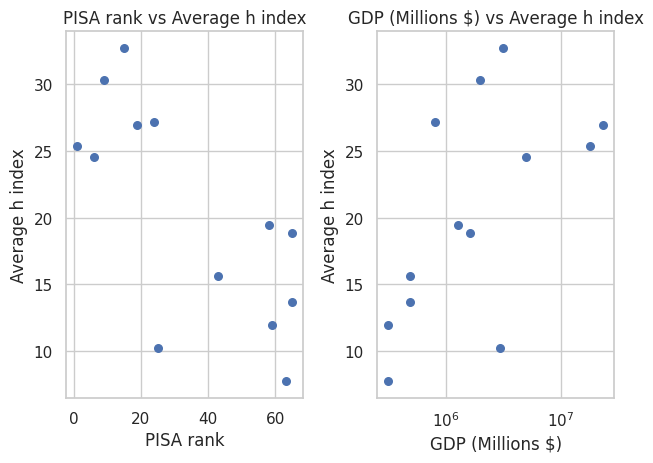

In [74]:
fig, (ax1, ax2) = plt.subplots(1, 2)

data={'PISA rank':mini_df['PISA rank'].tolist(),
      'Average h index':mini_df['Average h index'].tolist()}

tmp_df = pd.DataFrame(data = data);
tmp_df.plot.scatter(x = 'PISA rank', y = 'Average h index', s = 30, ax=ax1);

data={'GDP (Millions $)':mini_df['GDP (Millions $)'].tolist(),
      'Average h index':mini_df['Average h index'].tolist()}
  
tmp_df = pd.DataFrame(data = data);
tmp_df.plot.scatter(x = 'GDP (Millions $)', y = 'Average h index', s = 30, ax=ax2);

ax1.set_title("PISA rank vs Average h index");
ax2.set_title("GDP (Millions $) vs Average h index");
plt.xscale('log')
fig.tight_layout()

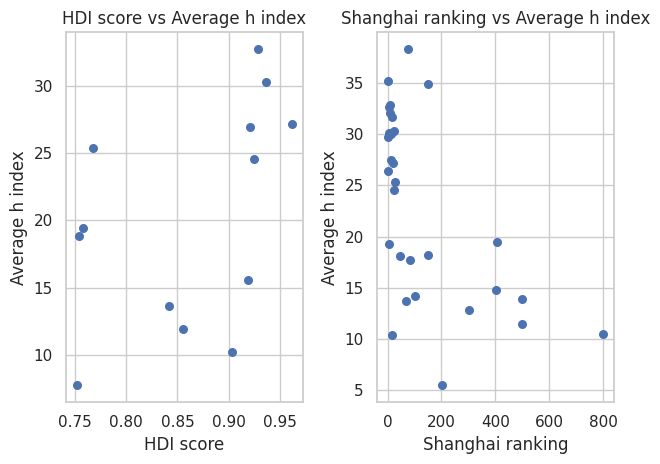

In [96]:
fig, (ax1,ax2) = plt.subplots(1, 2)

data={'HDI score':mini_df['HDI score'].tolist(),
      'Average h index':mini_df['Average h index'].tolist()}
  
tmp_df = pd.DataFrame(data = data);
tmp_df.plot.scatter(x = 'HDI score', y = 'Average h index', s = 30, ax=ax1);

ax1.set_title("HDI score vs Average h index");


df_shanghai = df.groupby(['Shanghai_ranking']).mean()["h index"]

Shanghai_ranking = [1,2,3,4,5,6,7,8,11,12,15,16,20,22,24,26,47,67,77,83,101,150,151,201,301,401,405,500,501,801]
lst_avg_per_shanghai = df_shanghai.tolist();

data={'Shanghai ranking':Shanghai_ranking,
      'Average h index':lst_avg_per_shanghai}
  
tmp_df = pd.DataFrame(data = data);
tmp_df.plot.scatter(x = 'Shanghai ranking', y = 'Average h index', s = 30, ax=ax2);

ax1.set_title("HDI score vs Average h index");
ax2.set_title("Shanghai ranking vs Average h index");
fig.tight_layout()

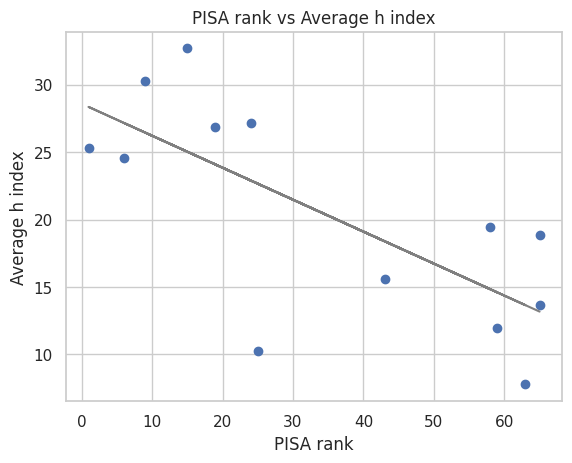

In [101]:
from sklearn.linear_model import LinearRegression

X1 = mini_df[['PISA rank']]
X2 = mini_df[['GDP (Millions $)']]
X3 = mini_df[['HDI score']]
y = mini_df['Average h index']

regressor1 = LinearRegression()
regressor1.fit(X1, y)

regressor2 = LinearRegression()
regressor2.fit(X2, y)

regressor3 = LinearRegression()
regressor3.fit(X3, y)

mini_df2 = pd.DataFrame({"Shanghai ranking":Shanghai_ranking, "Average h index":lst_avg_per_shanghai})
X4 = mini_df2[['Shanghai ranking']]
Y = mini_df2[['Average h index']]

regressor4 = LinearRegression()
regressor4.fit(X4, Y)

plt.scatter(X1, y)
plt.plot(X1, regressor1.predict(X1), color = "grey")

# plt.scatter(X2, y)
# plt.plot(X2, regressor2.predict(X2), color = "grey")
plt.title('PISA rank vs Average h index')
plt.xlabel('PISA rank')
plt.ylabel('Average h index')
plt.show()

In [108]:
print('PISA rank vs Average h index:\n\tR-squared = {:.3f}'.format(r2_score(y, regressor1.predict(X1))))
print('\tPearson correlation coefficient = R = {:.3f}'.format(mini_df.corr()['PISA rank'][0])+'\n')
print('GDP vs Average h index:\n\tR-squared = {:.3f}'.format(r2_score(y, regressor2.predict(X2))))
print('\tPearson correlation coefficient = R = {:.3f}'.format(mini_df.corr()['GDP (Millions $)'][0])+'\n')
print('HDI vs Average h index:\n\tR-squared = {:.3f}'.format(r2_score(y, regressor3.predict(X3))))
print('\tPearson correlation coefficient = R = {:.3f}'.format(mini_df.corr()['HDI score'][0])+'\n')
print('Shanghai ranking vs Average h index:\n\tR-squared = {:.3f}'.format(r2_score(Y, regressor4.predict(X4))))
print('\tPearson correlation coefficient = R = {:.3f}'.format(mini_df2.corr()['Shanghai ranking'][1]))

PISA rank vs Average h index:
	R-squared = 0.524
	Pearson correlation coefficient = R = -0.724

GDP vs Average h index:
	R-squared = 0.157
	Pearson correlation coefficient = R = 0.396

HDI vs Average h index:
	R-squared = 0.213
	Pearson correlation coefficient = R = 0.462

Shanghai ranking vs Average h index:
	R-squared = 0.343
	Pearson correlation coefficient = R = -0.586


* PISA rank of a nations is a good indicator for which country produce better scientists.  
* On the other hand, GDP has low impact, We assume it to be logarithmically (as we scale the x axis logarithmically it seems to have 'linear' correlation)
* We were suprised that the HDI score of a nation have a very little impact on the quality of its scientists

In [28]:
df.corr()["h index"].sort_values()

Shanghai_ranking   -0.301562
PISA rank          -0.289788
Position rank       0.053868
GDP (Millions $)    0.245993
Recommendations     0.296905
Reads               0.382567
Interest score      0.643960
Citations           0.791692
Publications        0.798109
h index             1.000000
Name: h index, dtype: float64

__In order to echive a higher corollations, We shall remove:__
* scientists whom hadn't decladered their level of degree or position in their institue.
* scientists whos publiction and citation are 0.

In [29]:
alternate_df = df[df['Position rank']>0]
alternate_df.corr()["h index"].sort_values()

Shanghai_ranking   -0.270394
PISA rank          -0.269722
Position rank       0.133634
GDP (Millions $)    0.216664
Recommendations     0.294765
Reads               0.375411
Interest score      0.621723
Publications        0.798140
Citations           0.799598
h index             1.000000
Name: h index, dtype: float64

We percive that the position rank has a very weak impact upon the h index.  
After removing all undecladered degree's scientists, and undergraduats, the improvement is from 0.047010 to 0.133629.  
We decide not removing those rows.

In [30]:
alternate_df = df[df['Publications']>0]
alternate_df = alternate_df[alternate_df['Citations']>0]
alternate_df.corr()["h index"].sort_values()

Shanghai_ranking   -0.295102
PISA rank          -0.286836
Position rank       0.034476
GDP (Millions $)    0.236937
Recommendations     0.295304
Reads               0.380229
Interest score      0.638217
Citations           0.793754
Publications        0.795960
h index             1.000000
Name: h index, dtype: float64

Again, removing scientists whom have no Publications and Citations have very weak improvement in the correlation with the h index

### Gender analysis

First, we wish to know, whether Male or Female are the majority in each academic positions:

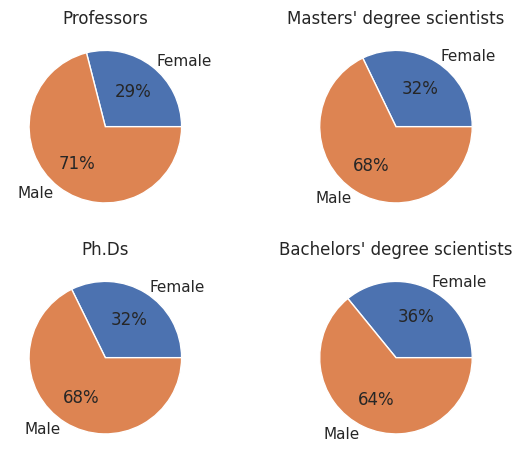

In [134]:
fig, axs = plt.subplots(2, 2)

mylabels = ['Female','Male']

tmp = df[df['Position rank'] == 4]
F_prof = len(tmp[tmp['Gender'] == 'Female'])
M_prof = len(tmp[tmp['Gender'] == 'Male'])

axs[0, 0].pie([F_prof, M_prof], labels = mylabels, autopct='%1.f%%');
axs[0, 0].set_title("Professors");

tmp = df[df['Position rank'] == 3]
F_phd = len(tmp[tmp['Gender'] == 'Female'])
M_phd = len(tmp[tmp['Gender'] == 'Male'])

axs[1, 0].pie([F_phd, M_phd], labels = mylabels, autopct='%1.f%%');
axs[1, 0].set_title("Ph.Ds");

tmp = df[df['Position rank'] == 2]
F_master = len(tmp[tmp['Gender'] == 'Female'])
M_master = len(tmp[tmp['Gender'] == 'Male'])

axs[0, 1].pie([F_master, M_master], labels = mylabels, autopct='%1.f%%');
axs[0, 1].set_title("Masters' degree scientists");

tmp = df[df['Position rank'] == 1]
F_bachelor = len(tmp[tmp['Gender'] == 'Female'])
M_bachelor = len(tmp[tmp['Gender'] == 'Male'])

axs[1, 1].pie([F_bachelor, M_bachelor], labels = mylabels, autopct='%1.f%%');
axs[1, 1].set_title("Bachelors' degree scientists");

fig.tight_layout()

# Machine learning models
Now we will remove all columns which irrelevant for the model:
* Gende -> covert to Female to 0 and Male to 1
* remove 'Full name'
* remove 'Position'
    * remove 'Nation'
    * remove 'Disciplines'
    * remove 'Depratment'
    * remove 'Institute'
* remove 'Top cited research'

In [69]:
import sklearn
model_df = df.drop(['Full name', 'Institute', 'Position', 'Nation', 
                    'Disciplines', 'Depratment', 'Top cited research'], axis=1)

le = sklearn.preprocessing.LabelEncoder()
model_df['Gender'] = le.fit_transform(model_df.Gender) 

# adding an average h index of a nation
Average_h_index = {"Israel":15.593223, "United States":26.894334, "Great Britain":32.698174, 
                   "France":10.220755, "Switzerland":27.167742, "Canada":30.270510, 
                   "Japan":24.569689,"China":25.345938,"Chile":11.978551,"Brazil":18.869754,
                   "Colombia":7.764674,"Mexico":19.434924,"Argentina":13.673216}

def country_to_average_h_index(country):
    avg = []
    for x in country:
        avg.append(Average_h_index[x])
    return avg

model_df['Average h index'] = country_to_average_h_index(df['Nation'])

model_df

Gender  Shanghai_ranking  Publications  Citations  Recommendations  \
0           1                47           183      11905               64   
1           1                47            62        234                5   
2           1                47            39        286               55   
3           0                47           152       4510               45   
4           1                47           235       3444              141   
...       ...               ...           ...        ...              ...   
36731       1               401             0          0                0   
36755       0               401            33        229                0   
36757       1               401             0          0                0   
36763       1               401             0          0                0   
36765       1               401             0          0                0   

       Interest score  Reads  h index  PISA rank  GDP (Millions $)  \
0                6087  33978       40         19          23315081   
1                1379   3586        9         19          23315081   
2                1959   4724        7         19          23315081   
3                2329  37724       39         19          23315081   
4                2294  48142       31         19          23315081   
...               ...    ...      ...        ...               ...   
36731               0      4        0         59            317059   
36755            1086    320        7         59            317059   
36757               0      2        0         59            317059   
36763               0      1        0         59            317059   
36765               0     14        0         59            317059   

       Position rank  HDI score  Average h index  
0                  3      0.921        26.894334  
1                  2      0.921        26.894334  
2                  3      0.921        26.894334  
3                  3      0.921        26.894334  
4                  3      0.921        26.894334  
...              ...        ...              ...  
36731              0      0.855        11.978551  
36755              0      0.855        11.978551  
36757              0      0.855        11.978551  
36763              0      0.855        11.978551  
36765              0      0.855        11.978551  

[33721 rows x 13 columns]

In [61]:
def load_dataset(file_name, target_column):
    df = pd.read_csv(file_name)
    return df.drop([target_column], axis=1), df[target_column].copy()
    

In [62]:
file_name = 'sientist_data_cleansing'
target_col_name = 'h index'

try:
    X, y = load_dataset(file_name, target_col_name)
except Exception as e:
    print ('\tError Message:', str(e))
    raise 

In [63]:
y

0        40
1         9
2         7
3        39
4        31
         ..
28423    32
28424    21
28425    23
28426    32
28427    16
Name: h index, Length: 28428, dtype: int64

In [68]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28428 entries, 0 to 28427
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Unnamed: 0          28428 non-null  int64 
 1   Full name           28428 non-null  object
 2   Gender              28428 non-null  object
 3   Position            28428 non-null  object
 4   Nation              28428 non-null  object
 5   Institute           28428 non-null  object
 6   Shanghai_ranking    28428 non-null  int64 
 7   Depratment          28428 non-null  object
 8   Disciplines         28428 non-null  object
 9   Publications        28428 non-null  int64 
 10  Citations           28428 non-null  int64 
 11  Recommendations     28428 non-null  int64 
 12  Top cited research  28428 non-null  object
 13  Interest score      28428 non-null  int64 
 14  Reads               28428 non-null  int64 
 15  URL                 27219 non-null  object
dtypes: int64(7), object(9)

In [69]:
X.describe(include='all')

Unnamed: 0  Full name Gender Position         Nation  \
count   28428.000000      28428  28428    28428          28428   
unique           NaN      28188      3     4997              8   
top              NaN  Tal Cohen   male      PhD  United States   
freq             NaN          4  27519     6402          10927   
mean    14588.539187        NaN    NaN      NaN            NaN   
std      8547.354880        NaN    NaN      NaN            NaN   
min         0.000000        NaN    NaN      NaN            NaN   
25%      7162.750000        NaN    NaN      NaN            NaN   
50%     14302.500000        NaN    NaN      NaN            NaN   
75%     22155.250000        NaN    NaN      NaN            NaN   
max     29296.000000        NaN    NaN      NaN            NaN   

                            Institute  Shanghai_ranking  \
count                           28428      28428.000000   
unique                             31               NaN   
top     Weizmann-Institute-of-Science               NaN   
freq                             1000               NaN   
mean                              NaN        177.988040   
std                               NaN        263.455342   
min                               NaN          1.000000   
25%                               NaN          8.000000   
50%                               NaN         24.000000   
75%                               NaN        301.000000   
max                               NaN        801.000000   

                     Depratment Disciplines  Publications      Citations  \
count                     28428       28428  28428.000000   28428.000000   
unique                     5018       21187           NaN            NaN   
top     Department of Chemistry         Nan           NaN            NaN   
freq                        561        5556           NaN            NaN   
mean                        NaN         NaN     92.198677    3885.976572   
std                         NaN         NaN    135.100014    9541.473850   
min                         NaN         NaN      0.000000       0.000000   
25%                         NaN         NaN     19.000000     171.750000   
50%                         NaN         NaN     50.000000    1041.500000   
75%                         NaN         NaN    110.000000    3544.000000   
max                         NaN         NaN   2923.000000  317018.000000   

        Recommendations Top cited research  Interest score         Reads  \
count      28428.000000              28428    28428.000000  2.842800e+04   
unique              NaN              23857             NaN           NaN   
top                 NaN                Nan             NaN           NaN   
freq                NaN               3106             NaN           NaN   
mean          49.050725                NaN     3559.091037  1.939902e+04   
std          168.683852                NaN     4821.799740  5.865871e+04   
min            0.000000                NaN        0.000000  0.000000e+00   
25%            3.000000                NaN     1033.000000  2.034500e+03   
50%           15.000000                NaN     2289.000000  7.479000e+03   
75%           45.000000                NaN     4917.250000  1.965875e+04   
max        13102.000000                NaN   150172.000000  3.726175e+06   

          URL  
count   27219  
unique  27191  
top         t  
freq        5  
mean      NaN  
std       NaN  
min       NaN  
25%       NaN  
50%       NaN  
75%       NaN  
max       NaN

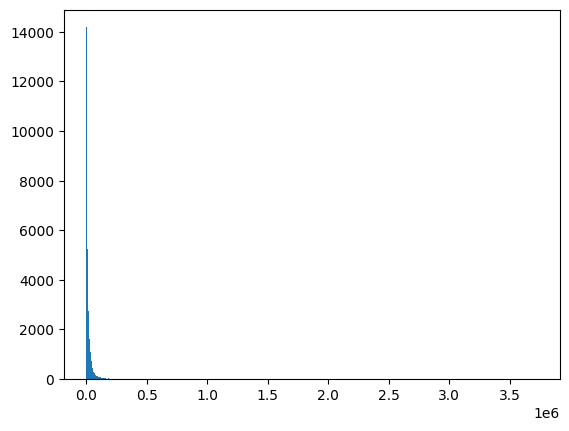

In [67]:
plt.hist(X.Reads, bins=500);